In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
(train_ds, train_labels), (test_ds, test_labels) = tfds.load(
"tf_flowers",split=["train[:70%]", "train[:30%]"], 
batch_size=-1,
as_supervised=True, 
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
train_ds = tf.image.resize(train_ds, (150, 150))
test_ds = tf.image.resize(test_ds, (150, 150))

train_labels = to_categorical(train_labels, num_classes=5)
test_labels = to_categorical(test_labels, num_classes=5)

#### AlexNet

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout

model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4),
activation='relu', input_shape=train_ds[0].shape))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1),
activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),
activation='relu', padding="same"))
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1),
activation='relu', padding="same"))
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1),
activation='relu', padding="same"))
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

In [5]:
train_ds = train_ds / 255.0
test_ds = test_ds / 255.0
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],)

In [7]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
history_alex = model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32,)

Epoch 1/50
65/65 [==============================] - 13s 38ms/step - loss: 1.6246 - accuracy: 0.2287 - val_loss: 1.6068 - val_accuracy: 0.2490
Epoch 2/50
65/65 [==============================] - 2s 25ms/step - loss: 1.6041 - accuracy: 0.2482 - val_loss: 1.6059 - val_accuracy: 0.2490
Epoch 3/50
65/65 [==============================] - 2s 25ms/step - loss: 1.6018 - accuracy: 0.2487 - val_loss: 1.6040 - val_accuracy: 0.2490
Epoch 4/50
65/65 [==============================] - 2s 25ms/step - loss: 1.6010 - accuracy: 0.2487 - val_loss: 1.6102 - val_accuracy: 0.2490
Epoch 5/50
65/65 [==============================] - 2s 25ms/step - loss: 1.6015 - accuracy: 0.2487 - val_loss: 1.6095 - val_accuracy: 0.2490
Epoch 6/50
65/65 [==============================] - 2s 25ms/step - loss: 1.6014 - accuracy: 0.2487 - val_loss: 1.6041 - val_accuracy: 0.2490
Epoch 7/50
65/65 [==============================] - 2s 24ms/step - loss: 1.6018 - accuracy: 0.2487 - val_loss: 1.6072 - val_accuracy: 0.2490
Epoch 8/50
6

#### VGG16

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models

base_model = VGG16(weights="imagenet", include_top=False,
input_shape=train_ds[0].shape)
base_model.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [9]:
train_ds = preprocess_input(train_ds)
test_ds = preprocess_input(test_ds)

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [11]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')
model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [13]:
model.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'],
)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
history = model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32,)

Epoch 1/50
65/65 [==============================] - 11s 111ms/step - loss: 1.6295 - accuracy: 0.2331 - val_loss: 1.6131 - val_accuracy: 0.2782
Epoch 2/50
65/65 [==============================] - 5s 84ms/step - loss: 1.6154 - accuracy: 0.2389 - val_loss: 1.6110 - val_accuracy: 0.2510
Epoch 3/50
65/65 [==============================] - 6s 85ms/step - loss: 1.6064 - accuracy: 0.2487 - val_loss: 1.6619 - val_accuracy: 0.2218
Epoch 4/50
65/65 [==============================] - 6s 86ms/step - loss: 1.6034 - accuracy: 0.2418 - val_loss: 1.6109 - val_accuracy: 0.2529
Epoch 5/50
65/65 [==============================] - 6s 87ms/step - loss: 1.5929 - accuracy: 0.2516 - val_loss: 1.5716 - val_accuracy: 0.2957
Epoch 6/50
65/65 [==============================] - 6s 86ms/step - loss: 1.5846 - accuracy: 0.2574 - val_loss: 1.5907 - val_accuracy: 0.2510
Epoch 7/50
65/65 [==============================] - 5s 85ms/step - loss: 1.5749 - accuracy: 0.2808 - val_loss: 1.5642 - val_accuracy: 0.3152
Epoch 8/50


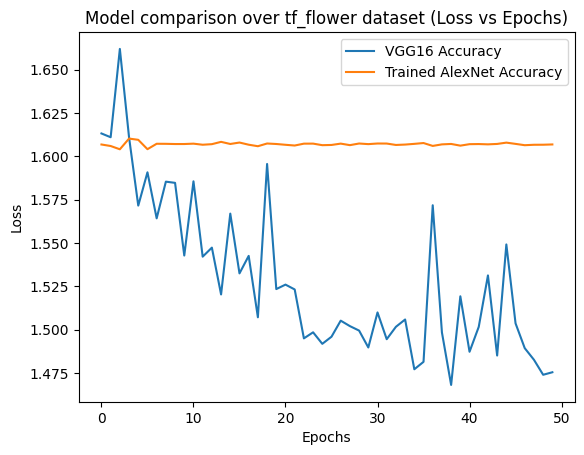

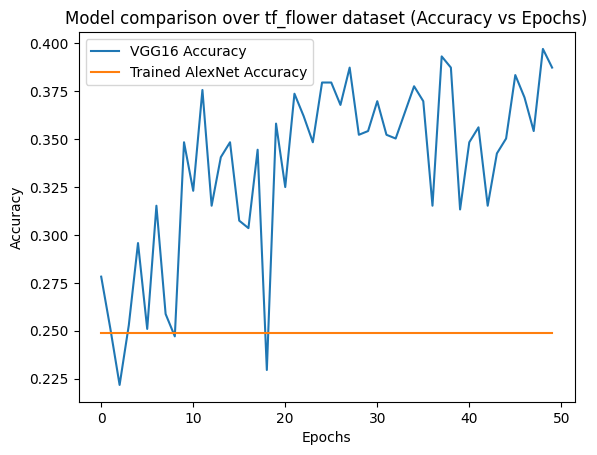

In [16]:
import matplotlib.pyplot as plt
plt.title("Model comparison over tf_flower dataset (Loss vs Epochs)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history["val_loss"], label = "VGG16 Accuracy")
plt.plot(history_alex.history["val_loss"], label = "Trained AlexNet Accuracy")
plt.legend()
plt.show()
plt.title("Model comparison over tf_flower dataset (Accuracy vs Epochs)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(history.history["val_accuracy"], label = "VGG16 Accuracy")
plt.plot(history_alex.history["val_accuracy"], label = "Trained AlexNet Accuracy")
plt.legend()
plt.show()